In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

# Carregamento dos dados

In [2]:
data_set_unformatted = pd.read_csv("./CompiledMeanDataRounded.csv", decimal=",", parse_dates=["Data"], infer_datetime_format=True).drop_duplicates()
data_set_unformatted.head()

,Data,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-29 12:00:00,60.18,9.35,1063.45,379.6,400.97,9.53,1.55,200.04,195.57,...,249.99,755.38,728.0,862.04,477.46,452.56,478.22,469.82,66.45,1.37
1,2017-03-29 13:00:00,60.18,9.35,2032.86,322.95,400.47,9.71,1.54,199.99,195.13,...,250.07,848.67,777.59,869.45,483.95,469.64,471.67,462.91,66.58,1.43
2,2017-03-29 14:00:00,60.18,9.35,1426.1,474.89,399.15,9.69,1.65,200.03,195.58,...,250.11,852.0,776.32,879.69,455.97,453.18,447.52,453.63,66.64,1.33
3,2017-03-29 15:00:00,60.18,9.35,616.73,395.13,398.94,9.86,1.56,199.94,195.61,...,250.04,855.89,780.4,882.1,449.4,448.52,450.87,448.41,66.4,1.3
4,2017-03-29 16:00:00,59.54,9.56,1369.26,318.08,400.82,9.94,1.54,199.89,196.25,...,250.12,851.58,784.47,884.86,450.22,451.9,451.58,449.39,63.65,5.48


In [3]:
data_set_unformatted = data_set_unformatted.to_numpy()
print(data_set_unformatted.shape)

(3948, 24)


## Normalização dos dados

In [4]:
data_set_unformatted = data_set_unformatted[:,1:-1]
print(data_set_unformatted.shape)

(3948, 22)


In [5]:
data_set_unformatted = np.array(data_set_unformatted, dtype=np.float32)

In [6]:
data_set = np.empty(data_set_unformatted.shape)
for i in range(data_set_unformatted.shape[1]):
    tag_max = np.max(data_set_unformatted[:, i])
    tag_min = np.min(data_set_unformatted[:, i])
    scope = tag_max - tag_min
    
    for j in range(data_set_unformatted.shape[0]):
        data_set[j, i] = (data_set_unformatted[j, i] - tag_min)/scope

# Divisão do dados em treinamento e teste

In [7]:
# Separando em conjunto de treinamento e teste
training_data = data_set[:2775,:]
test_data = data_set[2769:,:]

print(f"Training Samples: {training_data.shape[0] - 6}")
print(f"Test Samples: {test_data.shape[0] - 6}")

Training Samples: 2769
Test Samples: 1173


In [8]:
FEATURES_INPUT = data_set.shape[1] * 6
print(FEATURES_INPUT)

132


In [9]:
training_input = np.empty((training_data.shape[0] - 6, FEATURES_INPUT), dtype=np.float32)
training_label = np.empty((training_data.shape[0] - 6, 1), dtype=np.float32)

for i in range(6, training_data.shape[0]):
    training_input[i - 6,:] = training_data[i:i-6:-1,:].reshape(FEATURES_INPUT)
    training_label[i - 6] = training_data[i, 21]

print(training_input.shape)
print(training_label.shape)

training_input = torch.from_numpy(training_input)
training_label = torch.from_numpy(training_label)

(2769, 132)
(2769, 1)


In [10]:
test_input = np.empty((test_data.shape[0] - 6, FEATURES_INPUT), dtype=np.float32)
test_label = np.empty((test_data.shape[0] - 6, 1), dtype=np.float32)

for i in range(6, test_data.shape[0]):
    test_input[i - 6,:] = test_data[i:i-6:-1,:].reshape(FEATURES_INPUT)
    test_label[i - 6]   = test_data[i, 21]

test_input = torch.from_numpy(test_input)
test_label = torch.from_numpy(test_label)

test_input = torch.transpose(test_input, 0, 1)
test_label = torch.transpose(test_label, 0, 1)

print(test_input.size())
print(test_label.size())

torch.Size([132, 1173])
torch.Size([1, 1173])


# Implementação do Modelo

In [11]:
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden, input_size):
        super(LSTMPredictor, self).__init__()
        self.input_size = input_size
        self.n_hidden = n_hidden

        self.lstm1 = nn.LSTMCell(self.input_size, self.n_hidden )
        self.lstm2 = nn.LSTMCell(self.n_hidden , self.n_hidden )
        self.lstm3 = nn.LSTMCell(self.n_hidden , self.n_hidden )
        self.linear = nn.Linear(self.n_hidden , 1)

    def forward(self, input):

        outputs = []
        n_samples = 1

        h_t = torch.zeros(n_samples, self.n_hidden , dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.n_hidden , dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.n_hidden , dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.n_hidden , dtype=torch.float32)
        h_t3 = torch.zeros(n_samples, self.n_hidden , dtype=torch.float32)
        c_t3 = torch.zeros(n_samples, self.n_hidden , dtype=torch.float32)

        for input_t in input.split(1, dim=1):
            input_t = torch.transpose(input_t, 0, 1)
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3))
            output = self.linear(h_t3)
            outputs.append(output)
        
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [12]:
HIDDEN_SIZE = 30

In [13]:
model = LSTMPredictor(HIDDEN_SIZE, FEATURES_INPUT)

## Parametros de Treinamento

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
def train(line_tensor, category_tensor):
    line_tensor = torch.transpose(line_tensor, 0, 1)
    category_tensor = torch.transpose(category_tensor, 0, 1)

    out = model(line_tensor)
    loss = criterion(out, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [16]:
batch_size = 32

def random_sample():
    start = np.random.randint(training_input.shape[0] - batch_size)
    return training_input[start:start+batch_size,:], training_label[start:start+batch_size,:]

## Treinamento

epoch 1: 0.04061085730791092
epoch 2: 0.034239694476127625
epoch 3: 0.03968289494514465
epoch 4: 0.03281661495566368
epoch 5: 0.02977740950882435
epoch 6: 0.030759543180465698
epoch 7: 0.02533535659313202
epoch 8: 0.02256358042359352
epoch 9: 0.021238835528492928
epoch 10: 0.015927640721201897
epoch 11: 0.012803462333977222
epoch 12: 0.01443785522133112
epoch 13: 0.007130325306206942
epoch 14: 0.0071288649924099445
epoch 15: 0.006601644679903984
epoch 16: 0.0039622848853468895
epoch 17: 0.0029799207113683224
epoch 18: 0.0026705912314355373
epoch 19: 0.0023446425329893827
epoch 20: 0.002066905377432704
epoch 21: 0.0016983909299597144
epoch 22: 0.004712794907391071
epoch 23: 0.00297576398588717
epoch 24: 0.0012894711690023541
epoch 25: 0.0012756214709952474
epoch 26: 0.0011520093539729714
epoch 27: 0.0016663118731230497
epoch 28: 0.001443819492124021
epoch 29: 0.0019492345163598657
epoch 30: 0.0008746901876293123
epoch 31: 0.0008576352265663445
epoch 32: 0.0025461039040237665
epoch 33: 0

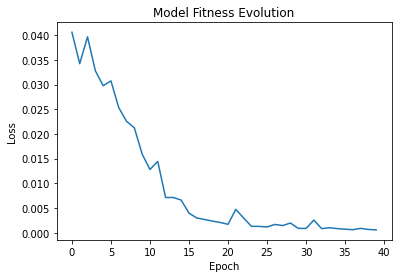

In [18]:
n_epochs = 40
n_batches = 42

all_losses = []

for i in range(n_epochs):
    
    # input_batch, category_batch = training_input, training_label
    for k in range(n_batches):
        input_batch, category_batch = random_sample()

        train(input_batch, category_batch)

    with torch.no_grad():
        out = model(test_input)
        loss = criterion(out, test_label)
        new_loss = loss.item()

        print(f"epoch {i+1}: {new_loss}")
        all_losses.append(new_loss)


plt.figure()
plt.title("Model Fitness Evolution")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(all_losses)

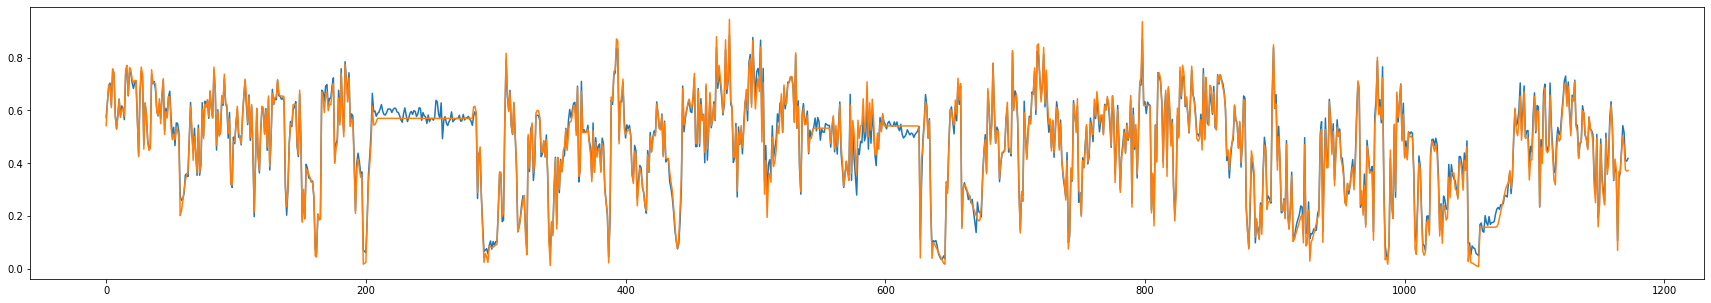

In [19]:
with torch.no_grad():
    out = model(test_input)
    plt.figure(figsize=(30, 5))
    plt.plot(out.numpy()[0])
    plt.plot(test_label.numpy()[0])